# GARCH Model Testing

In [55]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
import sklearn
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.preprocessing import StandardScaler


In [56]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')
print(df.head())
print(df.columns.tolist())

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

       Month   Bitcoin   Tether  Litecoin       XRP  Ethereum  Dogecoin  \
0 2017-09-01 -1.398923 -3.82830  -1.02849 -0.898590 -1.320943 -1.405018   
1 2017-10-01 -1.339539 -3.73861  -0.77151 -1.145490 -0.837982 -0.464897   
2 2017-11-01 -1.622995 -4.01951  -1.44830 -1.192080 -1.837874 -1.371050   
3 2017-12-01 -1.267670 -2.55687  -1.11575 -1.254630 -1.310402 -0.702095   
4 2018-01-01 -0.892511 -2.75193  -0.24164  0.038975 -0.811280 -0.334438   

   Cardano  USD Coin    VIX   MOVE  LFPR      CPI     r      M1    GDP  \
0      NaN       NaN  10.59  52.88  63.1  246.819  1.15  3535.6  60099   
1      NaN       NaN   9.51  51.15  62.7  246.663  1.15  3615.0  60674   
2      NaN       NaN  10.18  46.83  62.7  246.669  1.16  3587.6  60674   
3      NaN       NaN  11.28  46.60  62.7  246.524  1.30  3630.5  60674   
4      NaN       NaN  11.04  57.20  62.7  247.867  1.41  3673.4  61093   

         IM        EX     CC  CC Monthly % Change  Bitcoin Price  GDP Monthly  \
0  2916.022  2535.501  

## Testing all combinations

In [57]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC', 'CC Monthly % Change']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin','Bitcoin Price']
order = 1
train_end = '2023-05-01'

results_list = []

In [58]:
# Pre-difference all macro variables
for macro in macro_list:
    adf_p = adfuller(df[macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{macro}_diff'] = df[macro].diff()
        adf_p = adfuller(df[f'{macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{macro}_diff_diff'] = df[f'{macro}_diff'].diff()

## Forecasting Macro Mean

In [59]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.preprocessing import StandardScaler

results = []

for macro in macro_list:
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    for asset in asset_list:
        df_temp = df[[y_col, asset]].dropna().copy()
        if len(df_temp) < 30:
            print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
            continue

        y_var = df_temp[y_col].var()
        x_var = df_temp[asset].var()
        if y_var == 0 or x_var == 0:
            print(f"Skipping {macro}-{asset}: zero variance in y or x")
            continue

        scaler_y = StandardScaler()
        scaler_x = StandardScaler()

        y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
        x_scaled = scaler_x.fit_transform(df_temp[[asset]])

        try:
            model = arch_model(
                y_scaled,
                mean='ARX',
                lags=1,
                vol='GARCH',
                p=1,
                q=1,
                x=x_scaled,
                dist='normal'
            )
            res = model.fit(disp='off')

            # Collect exogenous regressor results, if present
            exog_params = [p for p in res.params.index if p.startswith('x')]
            if exog_params:
                for p_name in exog_params:
                    results.append({
                        'Macro': macro,
                        'Macro_col': y_col,
                        'Crypto': asset,
                        'Param': p_name,
                        'Coef': res.params[p_name],
                        'P-value': res.pvalues[p_name],
                        'AIC': res.aic,
                        'BIC': res.bic,
                        'Model_Success': True,
                    })
            else:
                # No exogenous regressor included
                results.append({
                    'Macro': macro,
                    'Macro_col': y_col,
                    'Crypto': asset,
                    'Param': None,
                    'Coef': np.nan,
                    'P-value': np.nan,
                    'AIC': res.aic,
                    'BIC': res.bic,
                    'Model_Success': True,
                })

            # print(f"Model fit successful for {macro}-{asset}")

        except Exception as e:
            print(f"Error fitting model for {macro}-{asset}: {e}")
            results.append({
                'Macro': macro,
                'Macro_col': y_col,
                'Crypto': asset,
                'Param': None,
                'Coef': np.nan,
                'P-value': np.nan,
                'AIC': np.nan,
                'BIC': np.nan,
                'Model_Success': False,
            })

# After loop, build and display results DataFrame
results_df = pd.DataFrame(results)

# Display full DataFrame without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(results_df.sort_values(by=['P-value'], na_position='last'))


,Macro,Macro_col,Crypto,Param,Coef,P-value,AIC,BIC,Model_Success
41,GDP,GDP_diff,Dogecoin,x0,-0.300676,0.002735,182.278567,197.074016,True
33,M1,M1_diff,Cardano,x0,0.065141,0.003673,247.682916,262.195960,True
5,LFPR,LFPR_diff,Dogecoin,x0,0.119087,0.008871,138.971346,153.766795,True
58,EX,EX_diff,Ethereum,x0,-0.138878,0.014556,241.749304,256.544753,True
59,EX,EX_diff,Dogecoin,x0,-0.303320,0.018290,231.230523,246.025972,True
27,M1,M1_diff,Bitcoin,x0,0.098992,0.019353,257.354388,272.149836,True
24,r,r_diff_diff,Cardano,x0,0.111803,0.020320,219.211212,233.724256,True
21,r,r_diff_diff,XRP,x0,0.124915,0.031272,226.600118,241.326202,True
61,EX,EX_diff,USD Coin,x0,-0.226032,0.039360,184.126596,197.786593,True
31,M1,M1_diff,Ethereum,x0,0.125091,0.045710,256.880112,271.675560,True


In [60]:
def plot_actual_vs_predicted(df, macro, asset, res):
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt

    # Determine differenced macro column used
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()

    # Scale the data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # Align for ARX(1): y[t] = const + phi*y[t-1] + beta*x[t]
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    predicted_mean_scaled = (
        res.params['Const']
        + res.params['y[1]'] * y_lag
        + res.params.get('x0', 0) * x_current
    )

    # Actual y from t=1 onward
    y_actual_scaled = y_scaled[1:]

    # Inverse transform to original scale
    predicted_mean = scaler_y.inverse_transform(predicted_mean_scaled.reshape(-1, 1)).flatten()
    y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_temp.index[-len(predicted_mean):], y_actual, label='Actual', marker='o')
    plt.plot(df_temp.index[-len(predicted_mean):], predicted_mean, label='Predicted Mean', linestyle='--', marker='x')
    plt.title(f'Actual vs Predicted {y_col} using {asset} in GARCH Mean')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.show()

    from sklearn.metrics import mean_squared_error, r2_score

    r2 = r2_score(y_actual, predicted_mean)
    mse = mean_squared_error(y_actual, predicted_mean)

    print(f"R²: {r2:.4f}, MSE: {mse:.4f}")


In [61]:
def plot_actual_vs_predicted_with_baseline(df, macro, asset, res):
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score
    from arch import arch_model

    # Determine differenced macro column used
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()

    # Scale the data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # ---------- ARX(1) model predictions (with crypto) ----------
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    predicted_arx_scaled = (
        res.params['Const']
        + res.params['y[1]'] * y_lag
        + res.params.get('x0', 0) * x_current
    )
    y_actual_scaled = y_scaled[1:]

    predicted_arx = scaler_y.inverse_transform(predicted_arx_scaled.reshape(-1, 1)).flatten()
    y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

    # ---------- AR(1) baseline model (no crypto) ----------
    model_ar = arch_model(y_scaled, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal')
    res_ar = model_ar.fit(disp="off")
    predicted_ar_scaled = res_ar.params['Const'] + res_ar.params['y[1]'] * y_scaled[:-1]
    predicted_ar = scaler_y.inverse_transform(predicted_ar_scaled.reshape(-1, 1)).flatten()

    # Align everything to same length
    y_actual_plot = y_actual[-len(predicted_ar):]
    predicted_arx_plot = predicted_arx[-len(predicted_ar):]

    # ---------- Plot ----------
    idx = df_temp.index[-len(predicted_ar):]

    plt.figure(figsize=(10, 6))
    plt.plot(idx, y_actual_plot, label='Actual', marker='o',markersize=1)
    plt.plot(idx, predicted_ar, label='Predicted AR(1) GARCH ', linestyle='--', marker='x',markersize=1)
    plt.plot(idx, predicted_arx_plot, label=f'Predicted ARX(1) GARCH + {asset}', linestyle='--', marker='s',markersize=1)
    plt.title(f'Actual vs Predicted {y_col} with and without {asset}')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Metrics ----------
    print("Model Comparison Metrics:")
    print(f"{'Metric':<10} | {'AR(1)':<12} | {'ARX + ' + asset:<15}")
    print("-" * 40)
    print(f"{'R²':<10} | {r2_score(y_actual_plot, predicted_ar):<12.4f} | {r2_score(y_actual_plot, predicted_arx_plot):<15.4f}")
    print(f"{'MSE':<10} | {mean_squared_error(y_actual_plot, predicted_ar):<12.4f} | {mean_squared_error(y_actual_plot, predicted_arx_plot):<15.4f}")


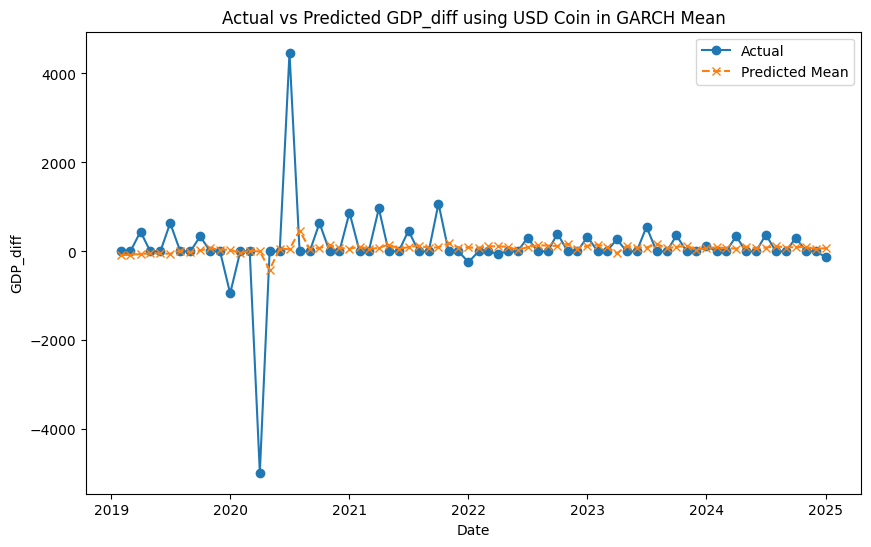

R²: -0.0051, MSE: 704056.1079


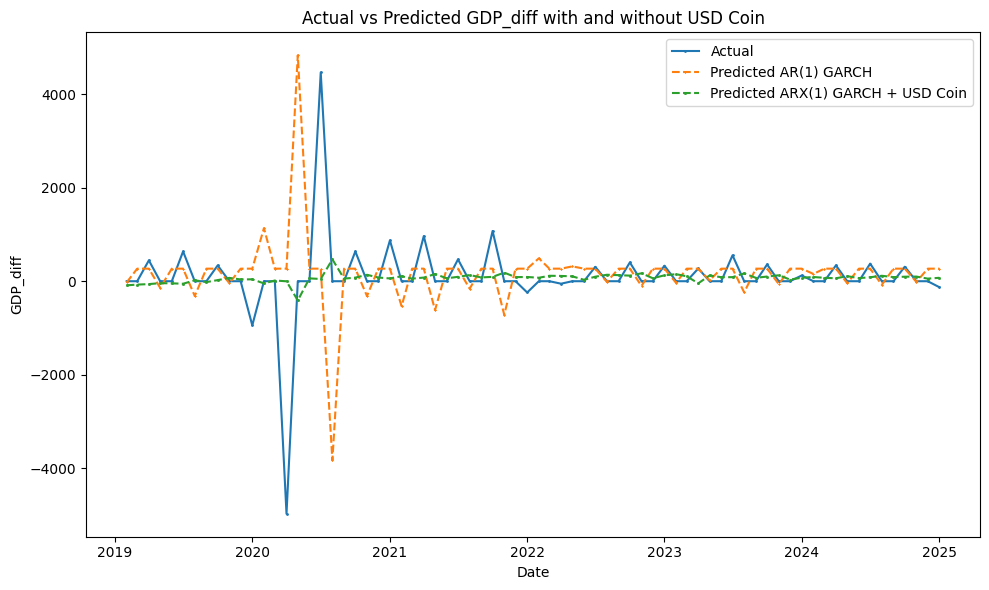

Model Comparison Metrics:
Metric     | AR(1)        | ARX + USD Coin 
----------------------------------------
R²         | -0.8246      | -0.0051        
MSE        | 1278125.5642 | 704056.1079    


In [62]:
# replace this with pairs as needed
plot_actual_vs_predicted(df, 'GDP', 'USD Coin', res)
plot_actual_vs_predicted_with_baseline(df, 'GDP', 'USD Coin', res)

## Metrics table

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

metrics = []

# Filter only successful models with valid exogenous terms
for row in results_df.dropna(subset=['Coef']).itertuples():
    macro = row.Macro
    macro_col = row.Macro_col
    asset = row.Crypto

    df_temp = df[[macro_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        continue

    # Standardize
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[macro_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    try:
        # Refit AR(1)
        model_ar = arch_model(y_scaled, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal')
        res_ar = model_ar.fit(disp='off')
        pred_ar_scaled = res_ar.params['Const'] + res_ar.params['y[1]'] * y_scaled[:-1]
        y_actual_ar_scaled = y_scaled[1:]
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        y_actual_ar = scaler_y.inverse_transform(y_actual_ar_scaled.reshape(-1, 1)).flatten()

        # Refit ARX(1)
        model_arx = arch_model(y_scaled, mean='ARX', lags=1, vol='GARCH', p=1, q=1, x=x_scaled, dist='normal')
        res_arx = model_arx.fit(disp='off')
        pred_arx_scaled = (
            res_arx.params['Const']
            + res_arx.params['y[1]'] * y_scaled[:-1]
            + res_arx.params.get('x0', 0) * x_scaled[1:]
        )
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual_arx = scaler_y.inverse_transform(y_scaled[1:].reshape(-1, 1)).flatten()

        # Metrics
        metrics.append({
            'Macro': macro,
            'Crypto': asset,
            'MSE_AR': mean_squared_error(y_actual_ar, pred_ar),
            'MSE_ARX': mean_squared_error(y_actual_arx, pred_arx),
            'RMSE_AR': np.sqrt(mean_squared_error(y_actual_ar, pred_ar)),
            'RMSE_ARX': np.sqrt(mean_squared_error(y_actual_arx, pred_arx)),
            'R2_AR': r2_score(y_actual_ar, pred_ar),
            'R2_ARX': r2_score(y_actual_arx, pred_arx),
            'MAPE_AR': mean_absolute_percentage_error(y_actual_ar, pred_ar),
            'MAPE_ARX': mean_absolute_percentage_error(y_actual_arx, pred_arx),
            'MSE_Diff': mean_squared_error(y_actual_ar, pred_ar) - mean_squared_error(y_actual_arx, pred_arx)
        })

    except Exception as e:
        print(f"Skipping {macro}-{asset} in metrics due to error: {e}")

# Build and show
metrics_df = pd.DataFrame(metrics)

# Optional: sort by improvement (e.g. MSE reduction)
metrics_df_sorted = metrics_df.sort_values(by='MSE_Diff', ascending=False)

# Show key results
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(metrics_df_sorted)


,Macro,Crypto,MSE_AR,MSE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX,MAPE_AR,MAPE_ARX,MSE_Diff
43,GDP,USD Coin,1.278126e+06,6.969153e+05,1130.542155,834.814503,-0.824586,0.005120,1.293454e+18,2.798323e+17,5.812103e+05
41,GDP,Dogecoin,1.026846e+06,6.250927e+05,1013.334115,790.628025,-0.760306,-0.071586,1.109658e+18,6.826681e+17,4.017534e+05
44,GDP,Bitcoin Price,1.026846e+06,9.868155e+05,1013.334115,993.385877,-0.760306,-0.691682,1.109658e+18,1.072004e+18,4.003053e+04
40,GDP,Ethereum,1.026846e+06,9.928974e+05,1013.334115,996.442361,-0.760306,-0.702108,1.109658e+18,1.067828e+18,3.394865e+04
42,GDP,Cardano,1.106868e+06,1.078574e+06,1052.078060,1038.544304,-0.814971,-0.768576,1.164754e+18,1.116534e+18,2.829397e+04
36,GDP,Bitcoin,1.026846e+06,9.993884e+05,1013.334115,999.694130,-0.760306,-0.713235,1.109658e+18,1.085827e+18,2.745767e+04
31,M1,Ethereum,1.460706e+06,1.436622e+06,1208.596676,1198.591702,0.005519,0.021915,2.971877e+00,3.699164e+00,2.408386e+04
39,GDP,XRP,1.026846e+06,1.004304e+06,1013.334115,1002.149659,-0.760306,-0.721662,1.109658e+18,1.083612e+18,2.254209e+04
27,M1,Bitcoin,1.460706e+06,1.444666e+06,1208.596676,1201.942408,0.005519,0.016439,2.971877e+00,3.238448e+00,1.604037e+04
33,M1,Cardano,1.531100e+06,1.522934e+06,1237.376453,1234.071946,0.004315,0.009626,2.503714e+00,3.573243e+00,8.166919e+03
